## Домашнее задание  

### Работа с набором данных Complete Pokemon Image Dataset

Необходимо выполнить полный цикл подготовки, обучения и оценки нейросетевой модели на наборе данных [Complete Pokemon Image Dataset](https://www.kaggle.com/datasets/hlrhegemony/pokemon-image-dataset/data)

#### Задачи  

1. **Загрузка данных**
    - Скачать данные набора **Complete Pokemon Image Dataset** с платформы Kaggle
2. **Создание набора данных с использованием библиотеки `datasets`**  
    - Использовать библиотеку `datasets` для обработки данных:  
        - Преобразовать данные в формат `datasets.Dataset`
        - Реализовать логику загрузки данных на основе директорий или словаря
3. **Создание нейросетевой модели**  
    - Построить архитектуру нейронной сети для задачи классификации с помощью `torch.nn`
4. **Обучение модели**  
    - Разделить данные на обучающую и тестовую выборки
    - Реализовать процесс обучения модели, сохраняя метрики (точность, ошибка и т.д.) и визуализации в `TensorBoard`
5. **Оценка результатов**  
    - Выполнить предсказания на тестовой и обучающей выборках
    - Визуализировать
        - Графики метрик обучения (точность, ошибка и т.д.)
        - Правильные и ошибочные предсказания
6. **Сохранение лучшей модели**  
    - Сохранить обученную модель в формате `state_dict` или аналогах
7. **Демонстрация работы модели**
    - Загрузить сохраненную модель
    - Показать визуализацию предсказаний модели на новых данных с указанием вероятностей классов
8. **Выводы**
    - Какие процессы не работают?
    - Какие проблемы были решены?
    - Какие метрики достигнуты?
    - Какие улучшения могли бы быть добавлены?

### Решение

In [1]:
# Подавление предупреждений
import warnings
for warn in [UserWarning, FutureWarning]: warnings.filterwarnings("ignore", category = warn)

# Импорт необходимых библиотек
import os
import random
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import datasets
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import tqdm
import logging

from dataclasses import dataclass
from typing import ClassVar

from torch.optim import Adam
from torchvision.transforms import v2
from torchvision import transforms as T
from torch.nn.utils.rnn import pad_sequence
from torch.utils.tensorboard.writer import SummaryWriter
from torch.utils.data import DataLoader
from datetime import datetime
from PIL import Image as PILImage, ImageFont, ImageDraw
from torchinfo import summary

from typing import List, Dict, Any, Tuple, Optional


from datasets import load_dataset, Dataset, DatasetDict, ClassLabel, Features
from sklearn.model_selection import train_test_split
from collections import defaultdict


### Загрузка данных

Произведена путем скачивания архива с Kaggel в директорию `./data/pokemon`

In [2]:
# Загрузка исходного датасета
data_dir = os.path.join(".", "data", "pokemon")
dataset = load_dataset("imagefolder", data_dir=data_dir)['train']

Resolving data files:   0%|          | 0/2503 [00:00<?, ?it/s]

### Создание набора данных с использованием библиотеки `datasets`

In [3]:
# Получаем имена классов из оригинального датасета
class_names = dataset.features['label'].names
label_feature = ClassLabel(names=class_names)
features = Features({
    'image': datasets.features.Image(),
    'label': label_feature
})

# Сначала делаем стратифицированное разделение на train и test
def stratified_split(dataset, test_size=0.2):
    class_indices = defaultdict(list)
    for idx, label in enumerate(dataset['label']):
        class_indices[label].append(idx)
    
    train_indices, test_indices = [], []
    for label, indices in class_indices.items():
        # Если в классе только 1 образец - добавляем его в train
        if len(indices) == 1:
            train_indices.extend(indices)
            continue
            
        cls_train, cls_test = train_test_split(
            indices, 
            test_size=test_size, 
            random_state=42
        )
        train_indices.extend(cls_train)
        test_indices.extend(cls_test)
    
    return dataset.select(train_indices), dataset.select(test_indices)

train_dataset_raw, test_dataset_raw = stratified_split(dataset)

# Аугментации для тренировочных данных
train_compose = v2.Compose([
    v2.RandomResizedCrop(size=(64, 64), antialias=True),
    v2.RandomRotation(degrees=(0, 90)),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomVerticalFlip(p=0.2),
    v2.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    v2.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    v2.RandomPerspective(distortion_scale=0.2, p=0.5),
])

# Для тестовых данных - только ресайз
test_compose = v2.Compose([
    v2.Resize(size=(64, 64)),
])

def augment_data(dataset, augment_times=10):
    augmented_data = defaultdict(list)
    
    for example in dataset:
        img = example['image']
        label = example['label']
        
        augmented_data['image'].append(img)
        augmented_data['label'].append(label)
        
        for _ in range(augment_times):
            augmented_img = train_compose(img)
            augmented_data['image'].append(augmented_img)
            augmented_data['label'].append(label)
    
    return Dataset.from_dict(augmented_data)

train_dataset_augmented = augment_data(train_dataset_raw)
test_dataset = test_dataset_raw

def to_tensor_normalize(img):
    tensor = v2.ToTensor()(img)
    return v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(tensor)

def apply_train_transforms(examples):
    examples["pixel_values"] = [to_tensor_normalize(train_compose(img)) for img in examples["image"]]
    return examples

def apply_test_transforms(examples):
    examples["pixel_values"] = [to_tensor_normalize(test_compose(img)) for img in examples["image"]]
    return examples

train_dataset_augmented.set_transform(apply_train_transforms)
test_dataset.set_transform(apply_test_transforms)

final_dataset = DatasetDict({
    'train': train_dataset_augmented.cast(features),
    'test': test_dataset.cast(features)
})

Casting the dataset:   0%|          | 0/17677 [00:00<?, ? examples/s]

### Создание нейросетевой модели (ResNet18)

In [4]:
class BasicBlock(nn.Module):
    expansion = 1
    
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels)
            )

    def forward(self, x):
        identity = self.shortcut(x)
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        out += identity
        out = self.relu(out)
        
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=898):
        super().__init__()
        self.in_channels = 64
        
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        
        return x

def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

### Обучение модели

In [5]:
# Запись событий в TensorBoard
# tensorboard --logdir=./homework/runs
log_dir = os.path.join(
    "runs", "hw-2" + "_" + datetime.now().strftime("%b%d_%H-%M-%S")
)
writer_tb = SummaryWriter(log_dir = log_dir)

In [6]:
SEED = 10091991 # SEED

torch.manual_seed(SEED)
np.random.seed(SEED) 
random.seed(SEED)

ROOT_DIR = os.path.join(".")

PATH_TO_FONT = os.path.join(ROOT_DIR, "fonts", "SegoeUI.ttf") # Путь до шрифта
PATH_TO_MODEL = os.path.join(ROOT_DIR, "models") # Путь для сохранения моделей
PATH_TO_CACHE = os.path.join(ROOT_DIR, "data") # Путь для загрузки наборов данных

SIZE_IMG = (28, 28) # Размер изображений
SIZE_IMG_SHOW = (256, 256) # Размер изображений для отображения

In [7]:
@dataclass
class ModelTrainer:
    model: nn.Module
    train_dataloader: DataLoader
    test_dataloader: DataLoader
    device: torch.device
    epochs: int
    round_loss: int
    round_acc: int

    optimizer: torch.optim
    
    patience: int = 5

    cond_image_comps: ClassVar[List[str]] = ["image", "img_show", "img_train", "img_test"]

    # Компоновщики изображений
    composer_img: ClassVar[Optional[v2.Compose]] = None
    composer_img_show: ClassVar[Optional[v2.Compose]] = None

    class_names: ClassVar[Optional[List[str]]] = None # Список имен классов

    loss_fn: ClassVar[Optional[torch.nn.modules.loss]] = None

    writer_tb: ClassVar[Optional[SummaryWriter]] = None

    # Вызывается сразу после __init__ при использовании dataclass
    def __post_init__(self):
        # ----------------------- Только для внутреннего использования внутри класса
        
        # История обучения и тестирования
        self.__history = pd.DataFrame({
            "train_acc": [], # Точность на тренировочной выборке
            "test_acc": [], # Точность на тестовой выборке
            "train_loss": [], # Loss на тренировочной выборке
            "test_loss": [] # Loss на тестовой выборке
        })

        # Количество шагов в одной эпохе
        self.__train_steps = len(self.train_dataloader)
        self.__test_steps = len(self.test_dataloader)

        self.__best_test_accuracy = 0
        self.__no_improvement_count = 0

    @property
    def history(self) -> pd.DataFrame:
        """Получение DataFrame историей обучения и тестирования

        Returns:
            pd.DataFrame: **DataFrame** c историей обучения и тестирования
        """

        return self.__history
    
    @classmethod
    def create_image_composers(cls, condition: str, size: Tuple[int, int]) -> None:
        """Создание компоновщика изображений

        Args:
            condition (str): Какие преобразования применить к изображению
            size (Tuple[int, int]): Размер, к которому будет изменено изображение

        Raises:
            ValueError: Если передано недопустимое значение
        """
        
        try:
            if condition == cls.cond_image_comps[0]:
                cls.composer_img = v2.Compose([
                    v2.Resize(size = size, antialias = True),
                ])
            elif condition == cls.cond_image_comps[1]:
                cls.composer_img_show = v2.Compose([
                    v2.Resize(size = size, antialias = True)
                ])
            elif condition == cls.cond_image_comps[2]:
                cls.composer_img_show = v2.Compose([
                    v2.Resize(size = size, antialias = True)
                ])
            else:
                return None
        except ValueError:
            return None

    @classmethod
    def transforms_data(cls, examples: Dict[str, Any]) -> Dict[str, Any]:
        """Применение преобразований к выборкам

        Args:
            examples (Dict[str, Any]): Словарь с примерами

        Returns:
            Dict[str, Any]: Словарь с преобразованными примерами
        """

        if cls.composer_img:
            examples[cls.cond_image_comps[0]] = list(map(cls.composer_img, examples[cls.cond_image_comps[0]]))

        if cls.composer_img_show:
            examples[cls.cond_image_comps[1]] = list(map(cls.composer_img_show, examples[cls.cond_image_comps[0]]))

        try:
            examples["label_name"] = list(map(lambda label: cls.class_names[label], examples["label"]))
        except TypeError:
            pass

        return examples

    @classmethod
    def get_model_logits(cls, logits: torch.Tensor) -> torch.Tensor:
        """Получение логитов модели в зависимости от функции потерь

        Args:
            logits (torch.Tensor): Входные логиты

        Returns:
            torch.Tensor: Обработанные логиты
        """

        if isinstance(cls.loss_fn, nn.NLLLoss):
            log_softmax = nn.LogSoftmax(dim = 1)
            return log_softmax(logits)
        elif isinstance(cls.loss_fn, nn.CrossEntropyLoss):
            return logits

    def _is_best_model(self, test_accuracy: float) -> bool:
        """Проверка, является ли текущая модель лучшей на основе точности тестирования

        Args:
            test_accuracy (float): Текущая точность тестирования

        Returns:
            bool: True, если текущая модель лучшая, иначе False
        """

        try:
            max_test_acc = max(self.__history["test_acc"])
        except ValueError:
            max_test_acc = 0
        return test_accuracy > max_test_acc

    def _save_model(self, epoch: int, path_to_model: str, test_accuracy: float, loss: torch.Tensor) -> None:
        """Сохранение модели

        Args:
            epoch (int): Текущая эпоха
            path_to_model (str): Путь для сохранения модели
            test_accuracy (float): Точность на тестовой выборке
            loss (torch.Tensor): Значение потерь
        """
        
        os.makedirs(path_to_model, exist_ok = True)

        torch.save({
            "epoch": epoch,
            "model_state_dict": self.model.state_dict(),
            "optimizer_state_dict": self.optimizer.state_dict(),
            "test_loss": loss,
        }, os.path.join(path_to_model, f"{model.__class__.__name__}_{epoch}_{test_accuracy}_checkpoint.pth"))

    @classmethod
    def visualize_samples_with_predictions(
        cls,
        model: nn.Module,
        device: torch.device,
        cid: datasets.Dataset,
        sample_name: str,
        path_to_font: str,
        cols: int = 10,
        rows: int = 3,
        fz: int = 20,
        pad: int = 10,
        outline_width: int = 0,
        border_thickness: int = 5,
        line_spacing: int = 5,
        seed: int = 42,
        top_k: int = 3  # Количество отображаемых топ-классов
    ) -> None:
        """Отображение примеров с предсказаниями и вероятностями классов"""
        
        font = ImageFont.truetype(path_to_font, size=fz)
        small_font = ImageFont.truetype(path_to_font, size=fz-4)  # Шрифт для вероятностей
        
        fig = plt.gcf()
        fig.set_size_inches(cols * 2.8, rows * 4.0)
        
        img_batch = []
        samples_idx = torch.randperm(len(cid), generator=torch.Generator().manual_seed(seed)).tolist()[:cols*rows]
        
        model.eval() if model else None
        
        for i, sample_idx in enumerate(samples_idx):    
            curr_cid = cid[sample_idx]
            if curr_cid is None: continue

            img_original, target, img_show, ntarget = curr_cid.values()
            
            # Создаем изображение с дополнительным местом для текста
            text_height = (top_k + 2) * (fz + 2)  # Высота текстовой области
            img_transparent = PILImage.new(
                'RGBA',
                (img_show.width, img_show.height + text_height + pad*2),
                (255, 255, 255, 0)
            )
            
            img_transparent.paste(img_show, (0, text_height + pad*2))
            draw = ImageDraw.Draw(img_transparent, 'RGBA')
            
            # Фон для текста
            draw.rectangle(
                [(0, 0), (img_show.width, text_height + pad*2)],
                fill=(255, 230, 204, 255),
                outline=(215, 154, 2, 255),
                width=outline_width
            )
            
            y_text = pad
            text_lines = []
            
            # Истинный класс
            true_class = f"True: {ntarget} (ID: {target})"
            text_lines.append(true_class)
            
            if model:
                with torch.no_grad():
                    img_tensor = v2.ToImage()(img_original).float().unsqueeze(0).to(device)
                    logits = model(img_tensor)
                    
                    if isinstance(cls.loss_fn, nn.NLLLoss):
                        probs = torch.exp(logits).squeeze()
                    else:
                        probs = torch.softmax(logits, dim=1).squeeze()
                    
                    pred = torch.argmax(probs).item()
                    pred_prob = probs[pred].item()
                    
                    # Топ-K предсказаний
                    top_probs, top_indices = torch.topk(probs, k=top_k)
                    for prob, idx in zip(top_probs, top_indices):
                        class_name = cls.class_names[idx.item()]
                        text_lines.append(f"{class_name}: {round(prob.item(), 2)}")
                    
                    border_color = (0, 255, 0, 255) if target == pred else (255, 0, 0, 255)
            else:
                border_color = (200, 200, 200, 255)
                text_lines.append("No model predictions")
            
            # Рисуем текст
            for j, line in enumerate(text_lines):
                if j == 0:
                    draw.text((pad, y_text), line, font=font, fill=(0, 0, 0, 255))
                else:
                    draw.text((pad*2, y_text), line, font=small_font, fill=(0, 0, 0, 255))
                y_text += (fz if j == 0 else fz-4) + 2
            
            # Добавляем рамку
            img_with_border = PILImage.new(
                'RGBA',
                (img_transparent.width + 2*border_thickness, 
                img_transparent.height + 2*border_thickness),
                (255, 255, 255, 0)
            )
            
            border_draw = ImageDraw.Draw(img_with_border, 'RGBA')
            border_draw.rectangle(
                [(0, 0), (img_with_border.width, img_with_border.height)],
                outline=border_color,
                width=border_thickness
            )
            
            img_with_border.paste(img_transparent, (border_thickness, border_thickness), img_transparent)
            
            img_show = T.PILToTensor()(img_with_border.convert('RGB'))
            img_batch.append(img_show)
            
            fig.add_subplot(rows, cols, i+1)
            plt.axis('off')
            plt.imshow(img_show.squeeze().permute(1, 2, 0))
        
        plt.subplots_adjust(wspace=0.1, hspace=0.2)
        plt.tight_layout(pad=line_spacing)
        plt.show()
        
        img_batch = pad_sequence(img_batch).squeeze().permute(1, 0, 2, 3)
        img_grid = vutils.make_grid(img_batch, nrow=cols)

        try:
            cls.writer_tb.add_image(f'Примеры из {sample_name} выборки', img_grid, seed)
        except:
            logging.error("Объект для записи событий в TensorBoard не найден")    

    # Процесс обучения
    def train(self, path_to_model: str) -> None:
        """Процесс обучения

        Args:
            path_to_model (str): Путь для сохранения моделей

        Returns:
            None
        """
        
        self.model.train() # Установка модели в режим обучения

        for epoch in range(1, self.epochs + 1):
            # Сумма Loss
            total_train_loss = 0
            total_test_loss = 0
            # Сумма точности
            train_accuracy = 0
            test_accuracy = 0

            # Проход по всем тренировочным пакетам
            with tqdm.tqdm(total = self.__train_steps, desc = f"Эпоха {epoch}", unit = "batch") as pbar_train:
                for batch, (imgs, targets) in enumerate(self.train_dataloader, 1):
                    # Перемещение данных на нужное устройство
                    imgs, targets = imgs.to(self.device), targets.to(self.device)

                    logits = self.model(imgs) # Пакет векторов необработанных (ненормализованных) предсказаний
                    m_logits = self.get_model_logits(logits)

                    loss = self.loss_fn(m_logits, targets) # Ошибка предсказаний

                    # Обратное распространение для обновления весов
                    self.optimizer.zero_grad()
                    loss.backward()
                    self.optimizer.step()
        
                    total_train_loss += loss.item() # Потеря
                    # Количество правильных предсказаний
                    train_accuracy += (logits.argmax(1) == targets).type(torch.float).sum().item()
        
                    pbar_train.update(1)

                # Средняя потеря
                avg_train_loss = round(total_train_loss / batch, self.round_loss)
                self.writer_tb.add_scalar("Средняя потеря/тренировочная", avg_train_loss, epoch)
        
                # Точность
                train_accuracy = round(train_accuracy / len(self.train_dataloader.dataset) * 100, self.round_acc)
                self.writer_tb.add_scalar("Точность/тренировочная", train_accuracy, epoch)
        
                pbar_train.set_postfix({
                    "Точность": train_accuracy,
                    "Средняя потеря": avg_train_loss
                })

            # Установка модели в режим предсказаний
            self.model.eval()
        
            # Предсказания на тестовой выборке
            with torch.no_grad():
                with tqdm.tqdm(total = self.__test_steps, desc = f"Тестирование {epoch}", unit = "batch") as pbar_test:
                    # Проход по всем тестовым пакетам
                    for batch, (imgs, targets) in enumerate(self.test_dataloader, 1):
                        # Перемещение данных на нужное устройство
                        imgs, targets = imgs.to(self.device), targets.to(self.device)
        
                        logits = self.model(imgs) # Пакет векторов необработанных (ненормализованных) прогнозов
                        m_logits = self.get_model_logits(logits)
                            
                        loss = self.loss_fn(m_logits, targets) # Ошибка предсказаний
                        
                        total_test_loss += loss.item() # Потеря
                        # Количество правильных предсказаний
                        test_accuracy += (logits.argmax(1) == targets).type(torch.float).sum().item()
        
                        pbar_test.update(1)

                    # Средняя потеря
                    avg_test_loss = round(total_test_loss / batch, self.round_loss)
                    self.writer_tb.add_scalar("Средняя потеря/тестовая", avg_test_loss, epoch)
        
                    # Точность
                    test_accuracy = round(test_accuracy / len(self.test_dataloader.dataset) * 100, self.round_acc)
                    self.writer_tb.add_scalar("Точность/тестовая", test_accuracy, epoch)
                    
                    pbar_test.set_postfix({
                        "Точность": test_accuracy,
                        "Средняя потеря": avg_test_loss
                    })
            
            if self._is_best_model(test_accuracy):
                self._save_model(epoch, path_to_model, test_accuracy, avg_test_loss)
                self.__best_test_accuracy = test_accuracy
                self.__no_improvement_count = 0
            else:
                self.__no_improvement_count += 1

            # Добавлениие данных в историю обучения
            new_row = pd.Series([train_accuracy, test_accuracy, avg_train_loss, avg_test_loss], index = self.__history.columns)
            self.__history = pd.concat([self.__history, new_row.to_frame().T], ignore_index = True)

            if self.__no_improvement_count >= self.patience:
                logging.info(f"Ранняя остановка на эпохе {epoch} из-за отсутствия улучшения точности на тестовой выборке")
                break

    # Получение хэш-значения
    def __hash__(self):
        return id(self)

In [8]:
dataset_train = final_dataset['train']
dataset_test = final_dataset['test']

In [9]:
ModelTrainer.create_image_composers("image", SIZE_IMG)
ModelTrainer.create_image_composers("img_show", SIZE_IMG_SHOW)

ModelTrainer.class_names = final_dataset['train'].features['label'].names

# Применение функции transforms для тренировочной подвыборки
dataset_train.set_transform(ModelTrainer.transforms_data)
# Применение функции transforms для тестовой подвыборки
dataset_test.set_transform(ModelTrainer.transforms_data)

In [10]:
EPOCHS = 20 # Количество эпох
BATCH_SIZE = 32 # Размер выборки (пакета)
LEARNING_RATE = 1e-4 # Скорость обучения
ROUND_ACC = 2 # Знаков Accuracy после запятой
ROUND_LOSS = 7 # Знаков Loss после запятой
# Проверка наличия GPU
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Формирование глобальных параметров для TensorBoard
learning_hyperparams = {
    "Гиперпараметр": [
        "Количество эпох", "Размер выборки (пакета)", "Скорость обучения",
        "Знаков Accuracy после запятой", "Знаков Loss после запятой",
        "Устройство для обучения"
    ],
    "Значение": [
        str(EPOCHS), BATCH_SIZE, LEARNING_RATE, ROUND_ACC, ROUND_LOSS, DEVICE
    ]
}

df_learning_hyperparams = pd.DataFrame(data = learning_hyperparams)
df_learning_hyperparams.index.name = "№"
df_learning_hyperparams.index += 1

display(df_learning_hyperparams)
# Отображение (TensorBoard)
writer_tb.add_text("Гиперпараметры для обучения", df_learning_hyperparams.to_markdown())

Гиперпараметр Значение
№                                        
1                Количество эпох       20
2        Размер выборки (пакета)       32
3              Скорость обучения   0.0001
4  Знаков Accuracy после запятой        2
5      Знаков Loss после запятой        7
6        Устройство для обучения      cpu

In [11]:
input_size = (BATCH_SIZE, *list(v2.ToTensor()(dataset_train[0]["image"]).shape))

# Создание экземпляра модели
model = ResNet18().to(DEVICE)

summary(
    model = model,
    input_size = input_size,
    col_names = ["input_size", "output_size", "num_params", "params_percent", "mult_adds", "trainable"],
    col_width = 15,
    mode = "train",
    verbose = 0,
    device = DEVICE
)

Layer (type:depth-idx)                   Input Shape     Output Shape    Param #         Param %         Mult-Adds       Trainable
ResNet                                   [32, 3, 28, 28] [32, 898]       --                   --         --              True
├─Conv2d: 1-1                            [32, 3, 28, 28] [32, 64, 28, 28] 1,728             0.01%         43,352,064      True
├─BatchNorm2d: 1-2                       [32, 64, 28, 28] [32, 64, 28, 28] 128               0.00%         4,096           True
├─ReLU: 1-3                              [32, 64, 28, 28] [32, 64, 28, 28] --                   --         --              --
├─MaxPool2d: 1-4                         [32, 64, 28, 28] [32, 64, 14, 14] --                   --         --              --
├─Sequential: 1-5                        [32, 64, 14, 14] [32, 64, 14, 14] --                   --         --              True
│    └─BasicBlock: 2-1                   [32, 64, 14, 14] [32, 64, 14, 14] --                   --         -

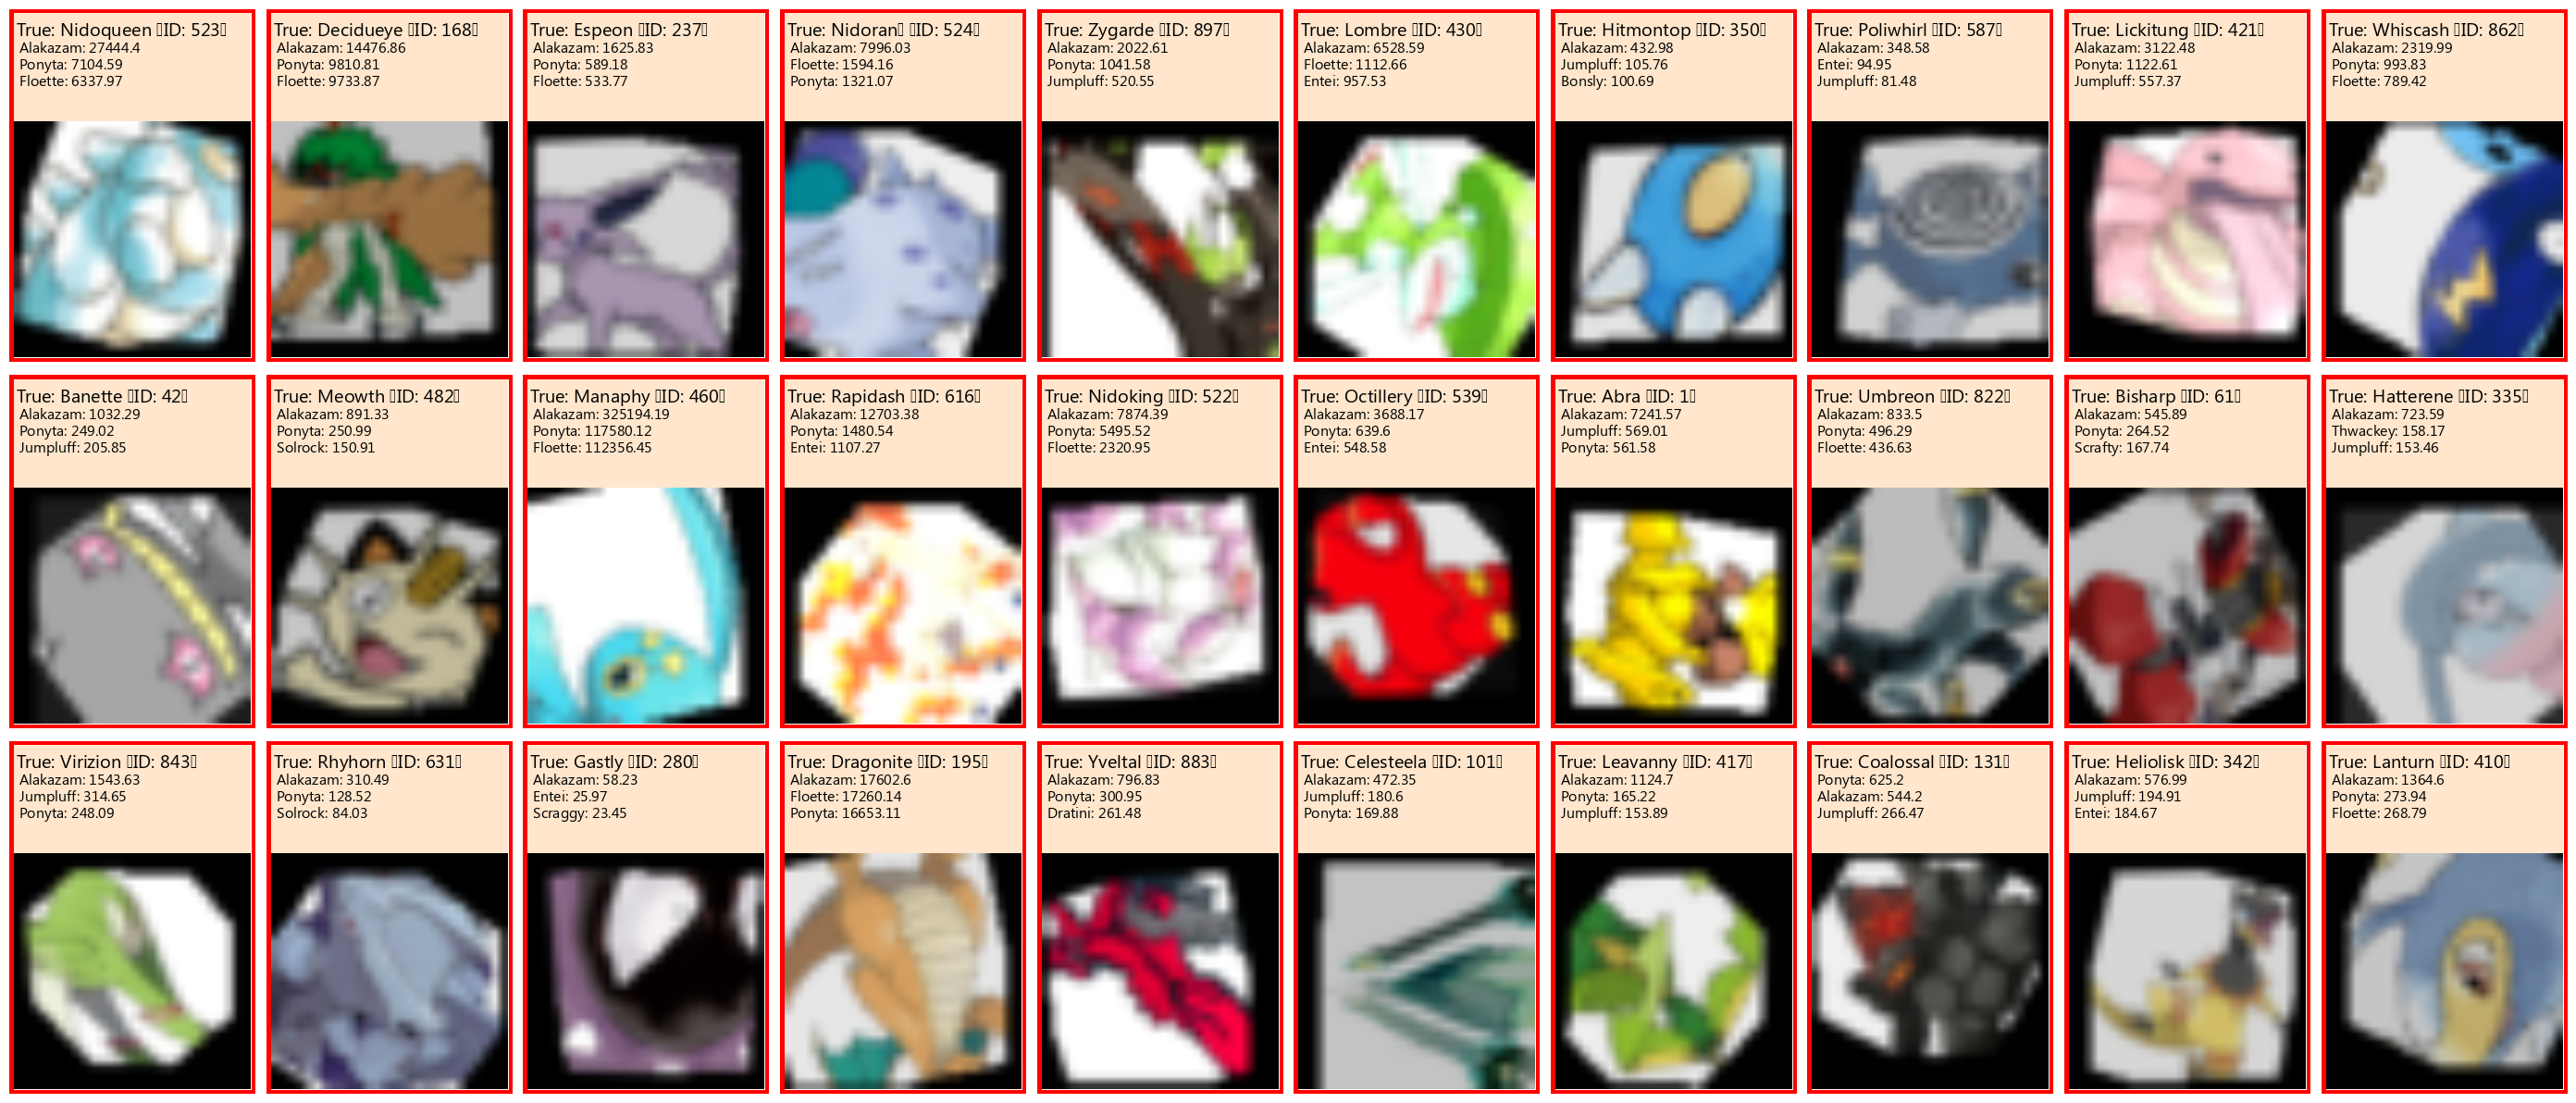

In [12]:
# Функция потерь (стоимость ошибок предсказаний)
ModelTrainer.loss_fn = nn.NLLLoss(reduction = "mean")
ModelTrainer.writer_tb = writer_tb

# Отображение примеров из обучающей выборки
ModelTrainer.visualize_samples_with_predictions(
    model = model,
    device = DEVICE,
    cid = dataset_train,
    sample_name = "тренировочной",
    path_to_font = PATH_TO_FONT,
    cols = 10,
    rows = 3,
    fz = 20,
    pad = 3,
    outline_width = 0,
    border_thickness = 5,
    line_spacing = 1,
    seed = SEED
)

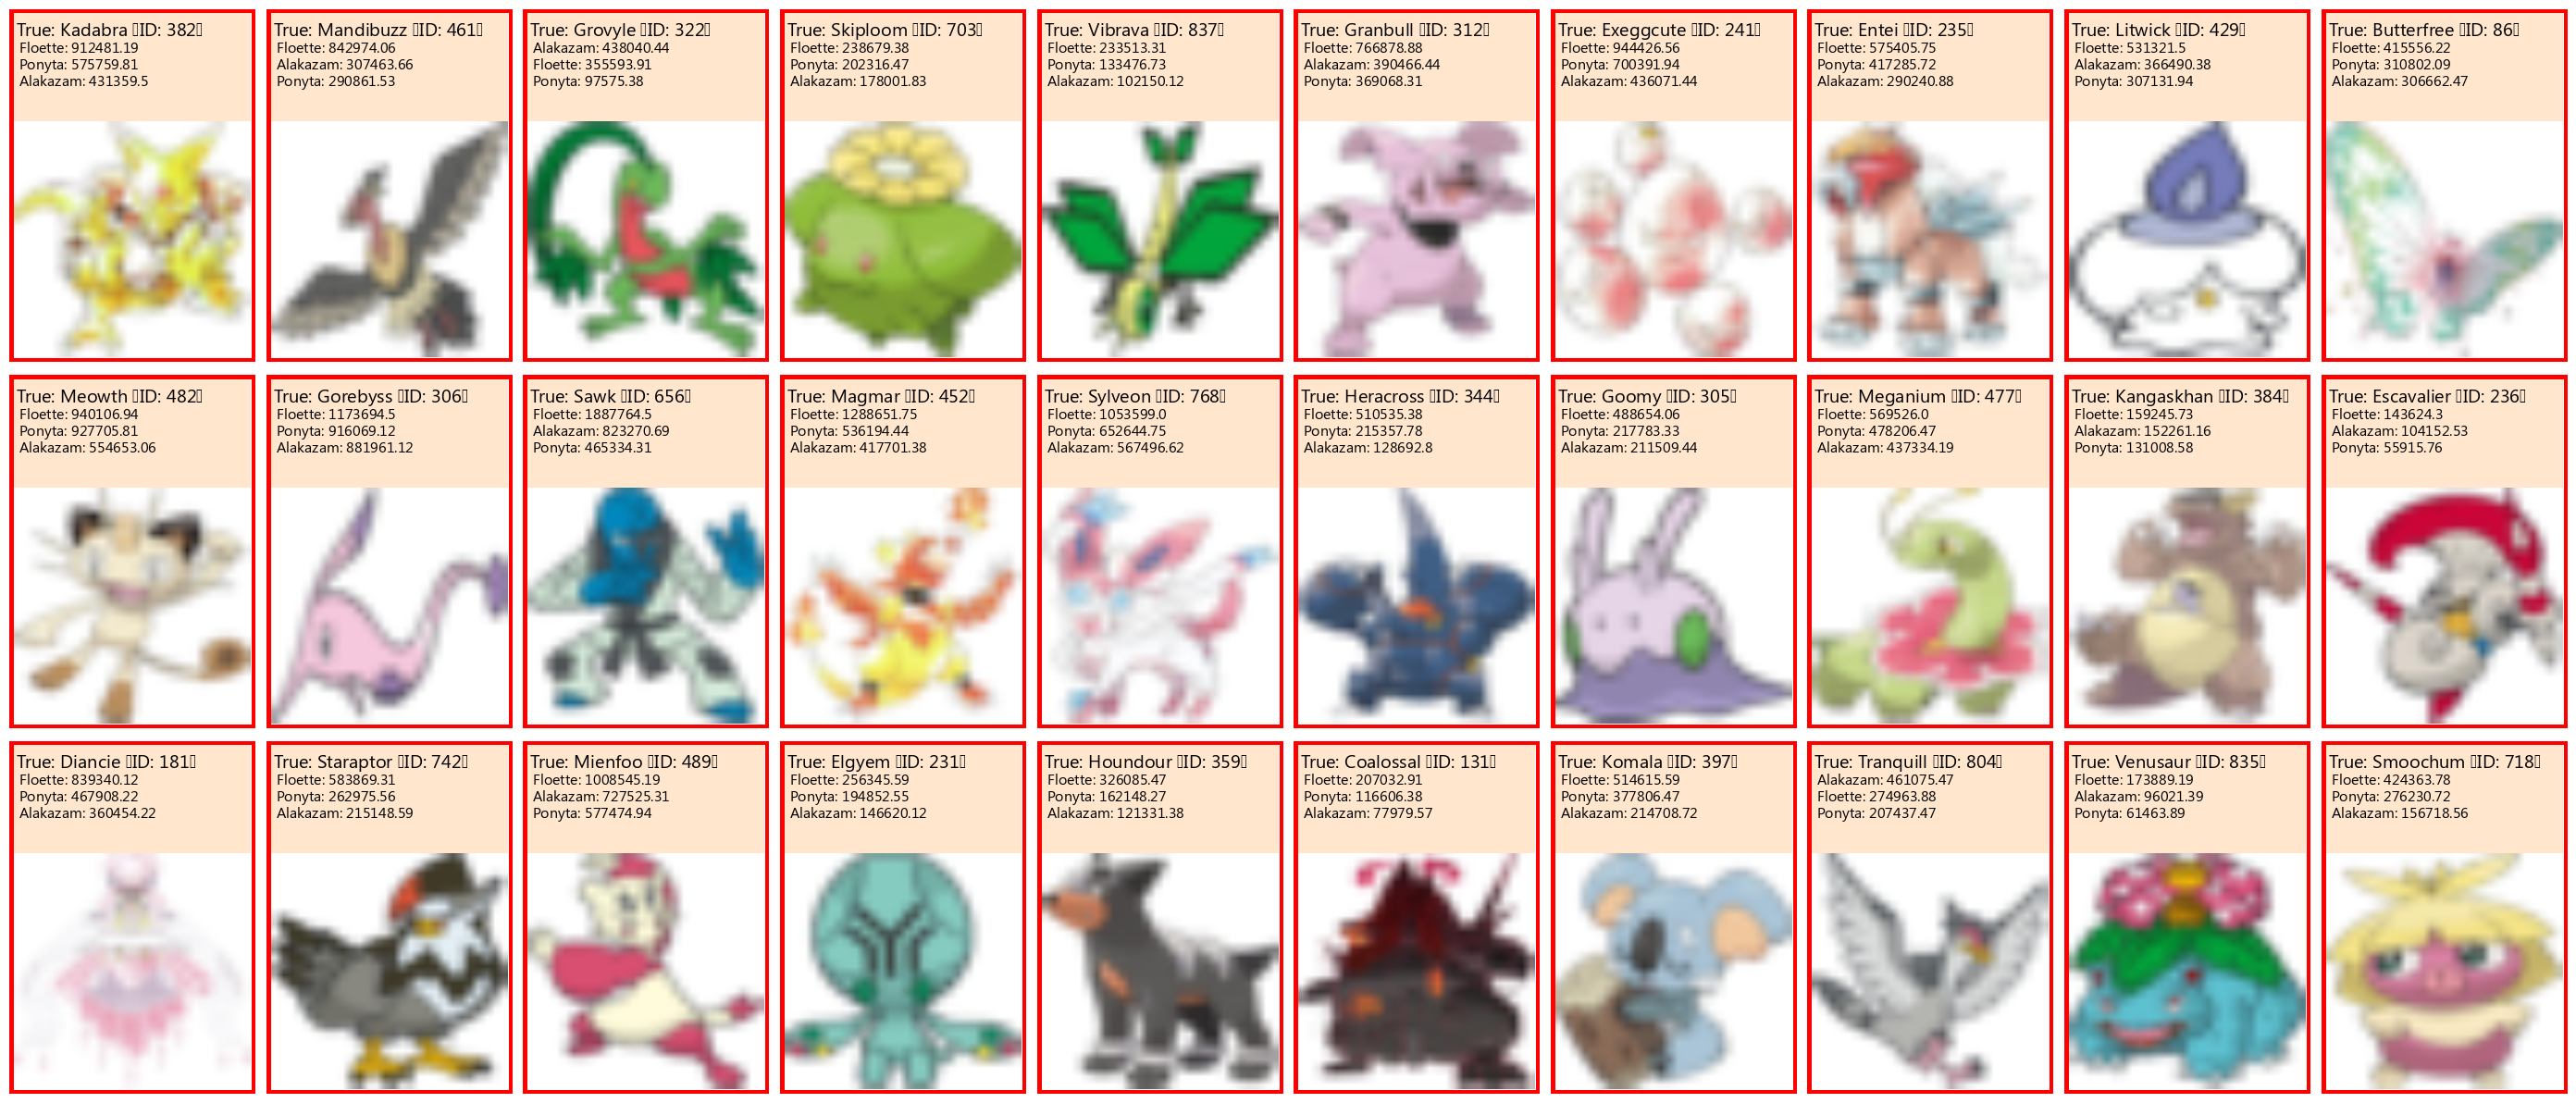

In [13]:
# Функция потерь (стоимость ошибок предсказаний)
ModelTrainer.loss_fn = nn.NLLLoss(reduction = "mean")
ModelTrainer.writer_tb = writer_tb

# Отображение примеров из тестовой поддвыборки
ModelTrainer.visualize_samples_with_predictions(
    model = model,
    device = DEVICE,
    cid = dataset_test,
    sample_name = "тестовой",
    path_to_font = PATH_TO_FONT,
    cols = 10,
    rows = 3,
    fz = 20,
    pad = 3,
    outline_width = 0,
    border_thickness = 5,
    line_spacing = 1,
    seed = SEED
)

In [14]:
dataset_format_train = dataset_train.with_format(type = "torch", columns = ["image", "label"])
dataset_format_test = dataset_test.with_format(type = "torch", columns = ["image", "label"])

In [15]:
try:
    compose_img = v2.Compose([
        v2.ToImage(),
        v2.Resize(size = SIZE_IMG, antialias = True),
    ])
except ValueError:
    compose_img = None

def transforms_format_train(examples: dict):
    if compose_img:
        # Применение преобразований ко всем изображениям (img) и сохранение результатов (img)
        examples["image"] = list(map(compose_img, examples["image"]))

    return examples # Результат

def transforms_format_test(examples: dict):
    if compose_img:
        # Применение преобразований ко всем изображениям (img) и сохранение результатов (img)
        examples["image"] = list(map(compose_img, examples["image"]))

    return examples # Результат

# Применение функции transforms для тренировочной подвыборки
dataset_format_train.set_transform(transforms_format_train)
# Применение функции transforms для тестовой подвыборки
dataset_format_test.set_transform(transforms_format_test)

In [16]:
gen = torch.Generator()  # Генератор
gen.manual_seed(SEED)

def collate_batch(batch):
    # Получаем список тензоров изображений и меток
    imgs = [item["image"].float() for item in batch]  # Каждый тензор имеет размер [C, H, W]
    targets = torch.tensor([item["label"] for item in batch])
    
    # Собираем тензоры изображений в один пакет
    imgs = torch.stack(imgs)  # Результат будет [N, C, H, W]
    
    return imgs, targets

train_dataloader = DataLoader(
    dataset_format_train, 
    batch_size=BATCH_SIZE, 
    generator=gen, 
    shuffle=True, 
    drop_last=False, 
    collate_fn=collate_batch,
    pin_memory=True if torch.cuda.is_available() else False
)

test_dataloader = DataLoader(
    dataset_format_test, 
    batch_size=BATCH_SIZE, 
    generator=gen, 
    shuffle=False, 
    drop_last=False, 
    collate_fn=collate_batch,
    pin_memory=True if torch.cuda.is_available() else False
)

# Проверка размерностей
train_dataiter = iter(train_dataloader)
img, target = next(train_dataiter)
print("Размер пакета с тренировочными изображениями [N, C, H, W]:", img.shape)
print("Метки:", target.shape, target.dtype)
    
test_dataiter = iter(test_dataloader)
img, target = next(test_dataiter)
print("Размер пакета с тестовыми изображениями [N, C, H, W]:", img.shape)
print("Метки:", target.shape, target.dtype)

Размер пакета с тренировочными изображениями [N, C, H, W]: torch.Size([32, 3, 28, 28])
Метки: torch.Size([32]) torch.int64
Размер пакета с тестовыми изображениями [N, C, H, W]: torch.Size([32, 3, 28, 28])
Метки: torch.Size([32]) torch.int64


In [17]:
logging.basicConfig(level = logging.INFO)

# Оптимизация параметров нейросетевой модели для минимизации функции потерь
optimizer = Adam(params = model.parameters(), lr = LEARNING_RATE)
# Функция потерь (стоимость ошибок предсказаний)
loss_fn = nn.NLLLoss(reduction = "mean")

trainer = ModelTrainer(model, train_dataloader, test_dataloader, DEVICE, EPOCHS, ROUND_LOSS, ROUND_ACC, optimizer)

trainer.train(PATH_TO_MODEL)

Тестирование 19: 100%|██████████| 28/28 [00:02<00:00, 11.95batch/s, Точность=22.9, Средняя потеря=8.14]
INFO:root:Ранняя остановка на эпохе 19 из-за отсутствия улучшения точности на тестовой выборке


### Сохранение лучшей модели, Демонстрация работы модели и Оценка результатов

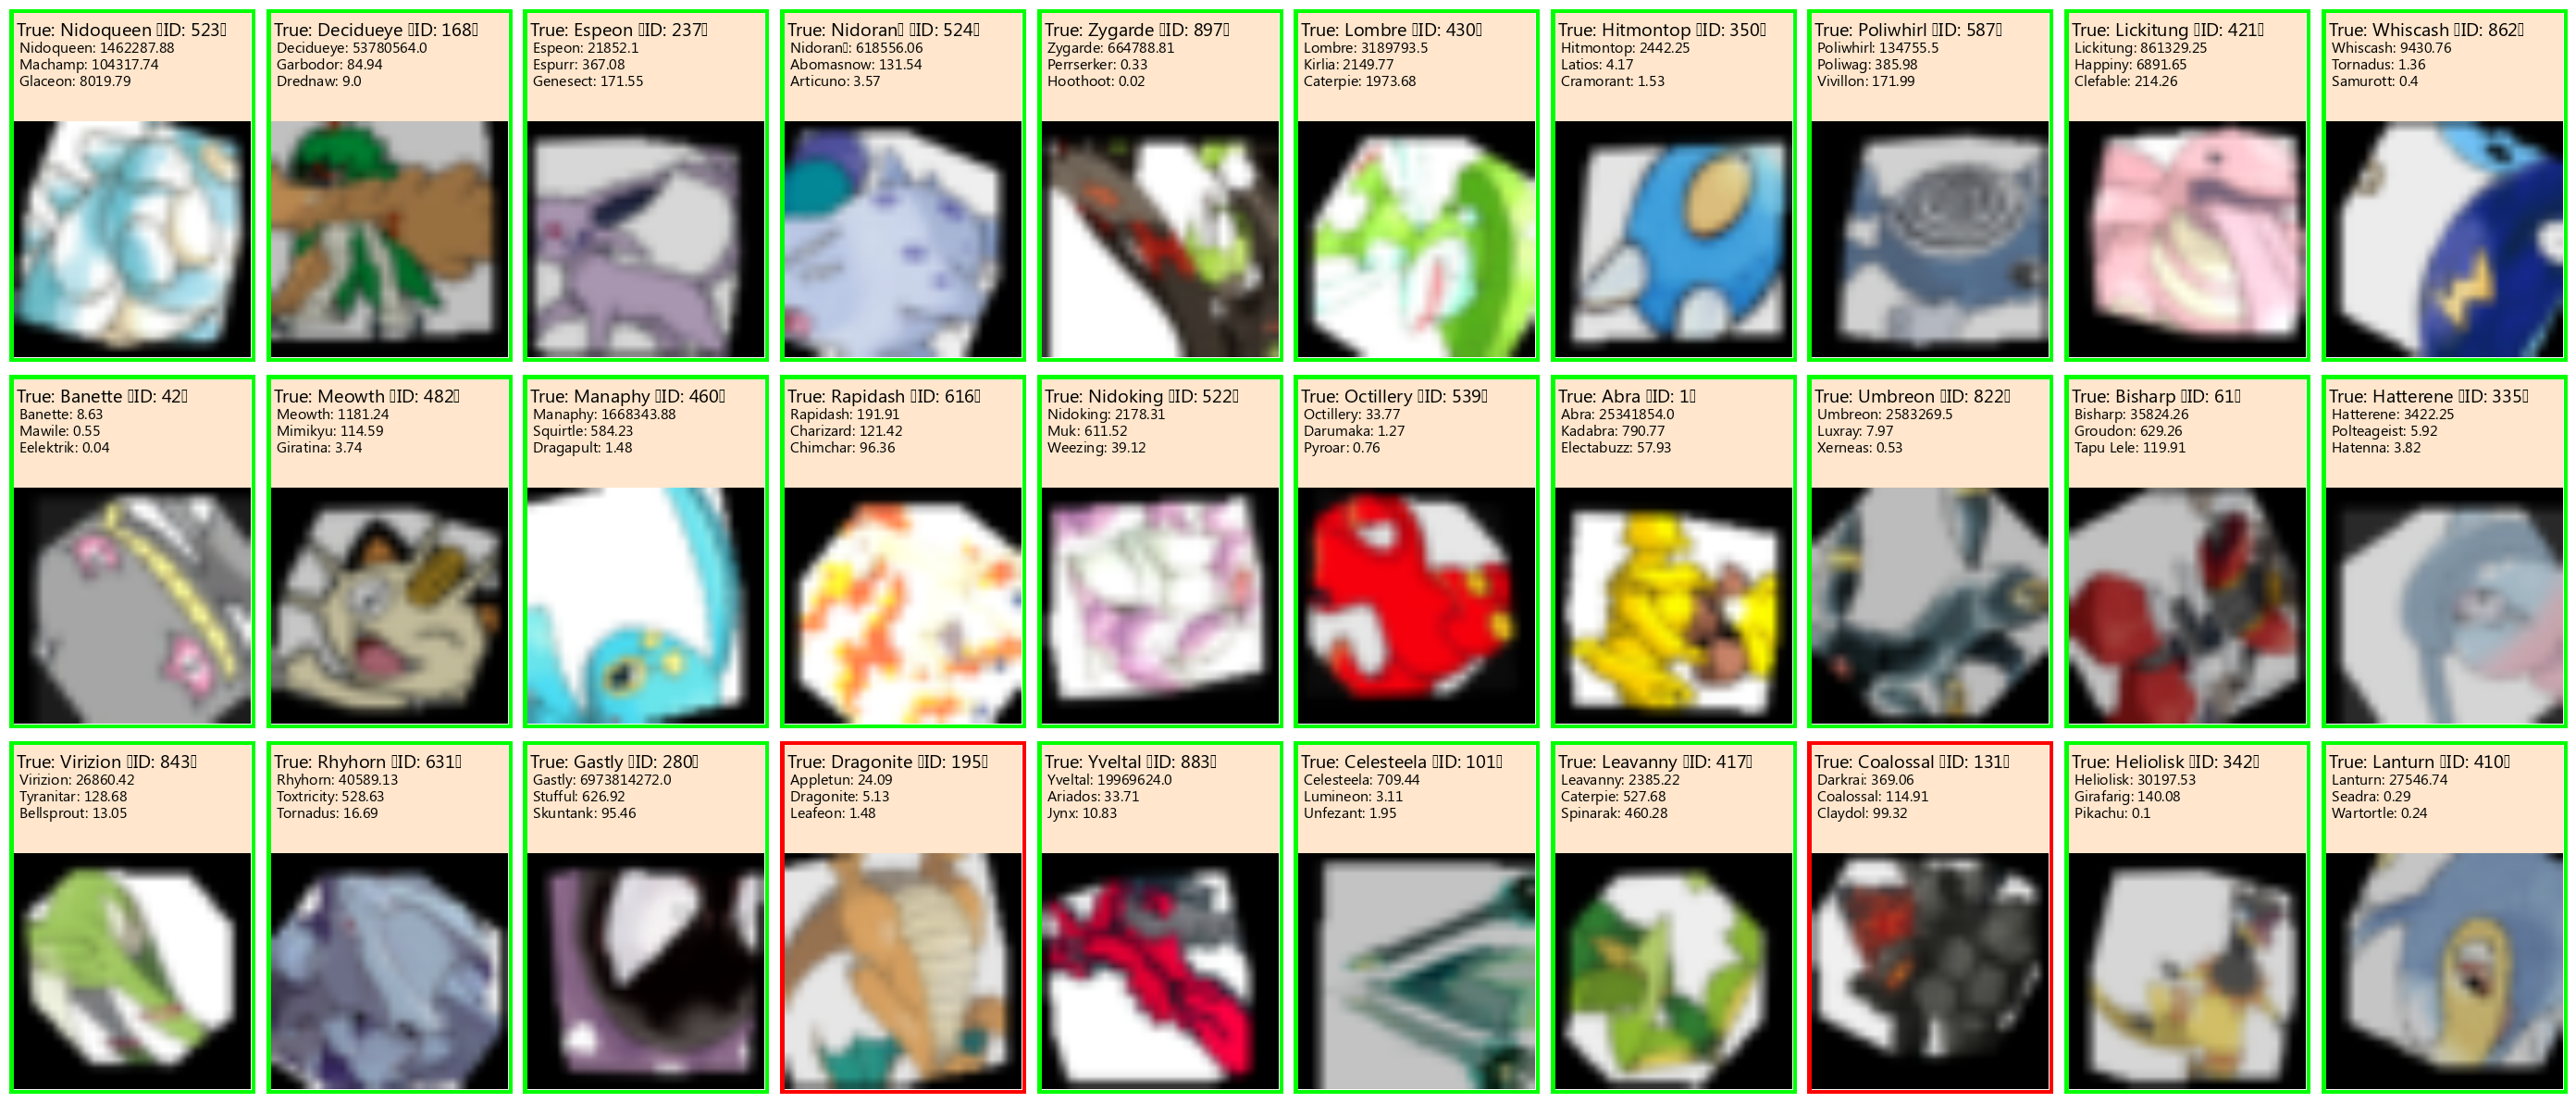

In [19]:
# Создание экземпляра модели
model = ResNet18().to(DEVICE)

checkpoint = torch.load(os.path.join(PATH_TO_MODEL, "ResNet_14_22.88_checkpoint.pth"))
model.load_state_dict(checkpoint['model_state_dict'])

# Отображение примеров из тренировочной поддвыборки
ModelTrainer.visualize_samples_with_predictions(
    model = model,
    device = DEVICE,
    cid = dataset_train,
    sample_name = "тренировочной",
    path_to_font = PATH_TO_FONT,
    cols = 10,
    rows = 3,
    fz = 20,
    pad = 3,
    outline_width = 0,
    border_thickness = 5,
    line_spacing = 1,
    seed = SEED
)

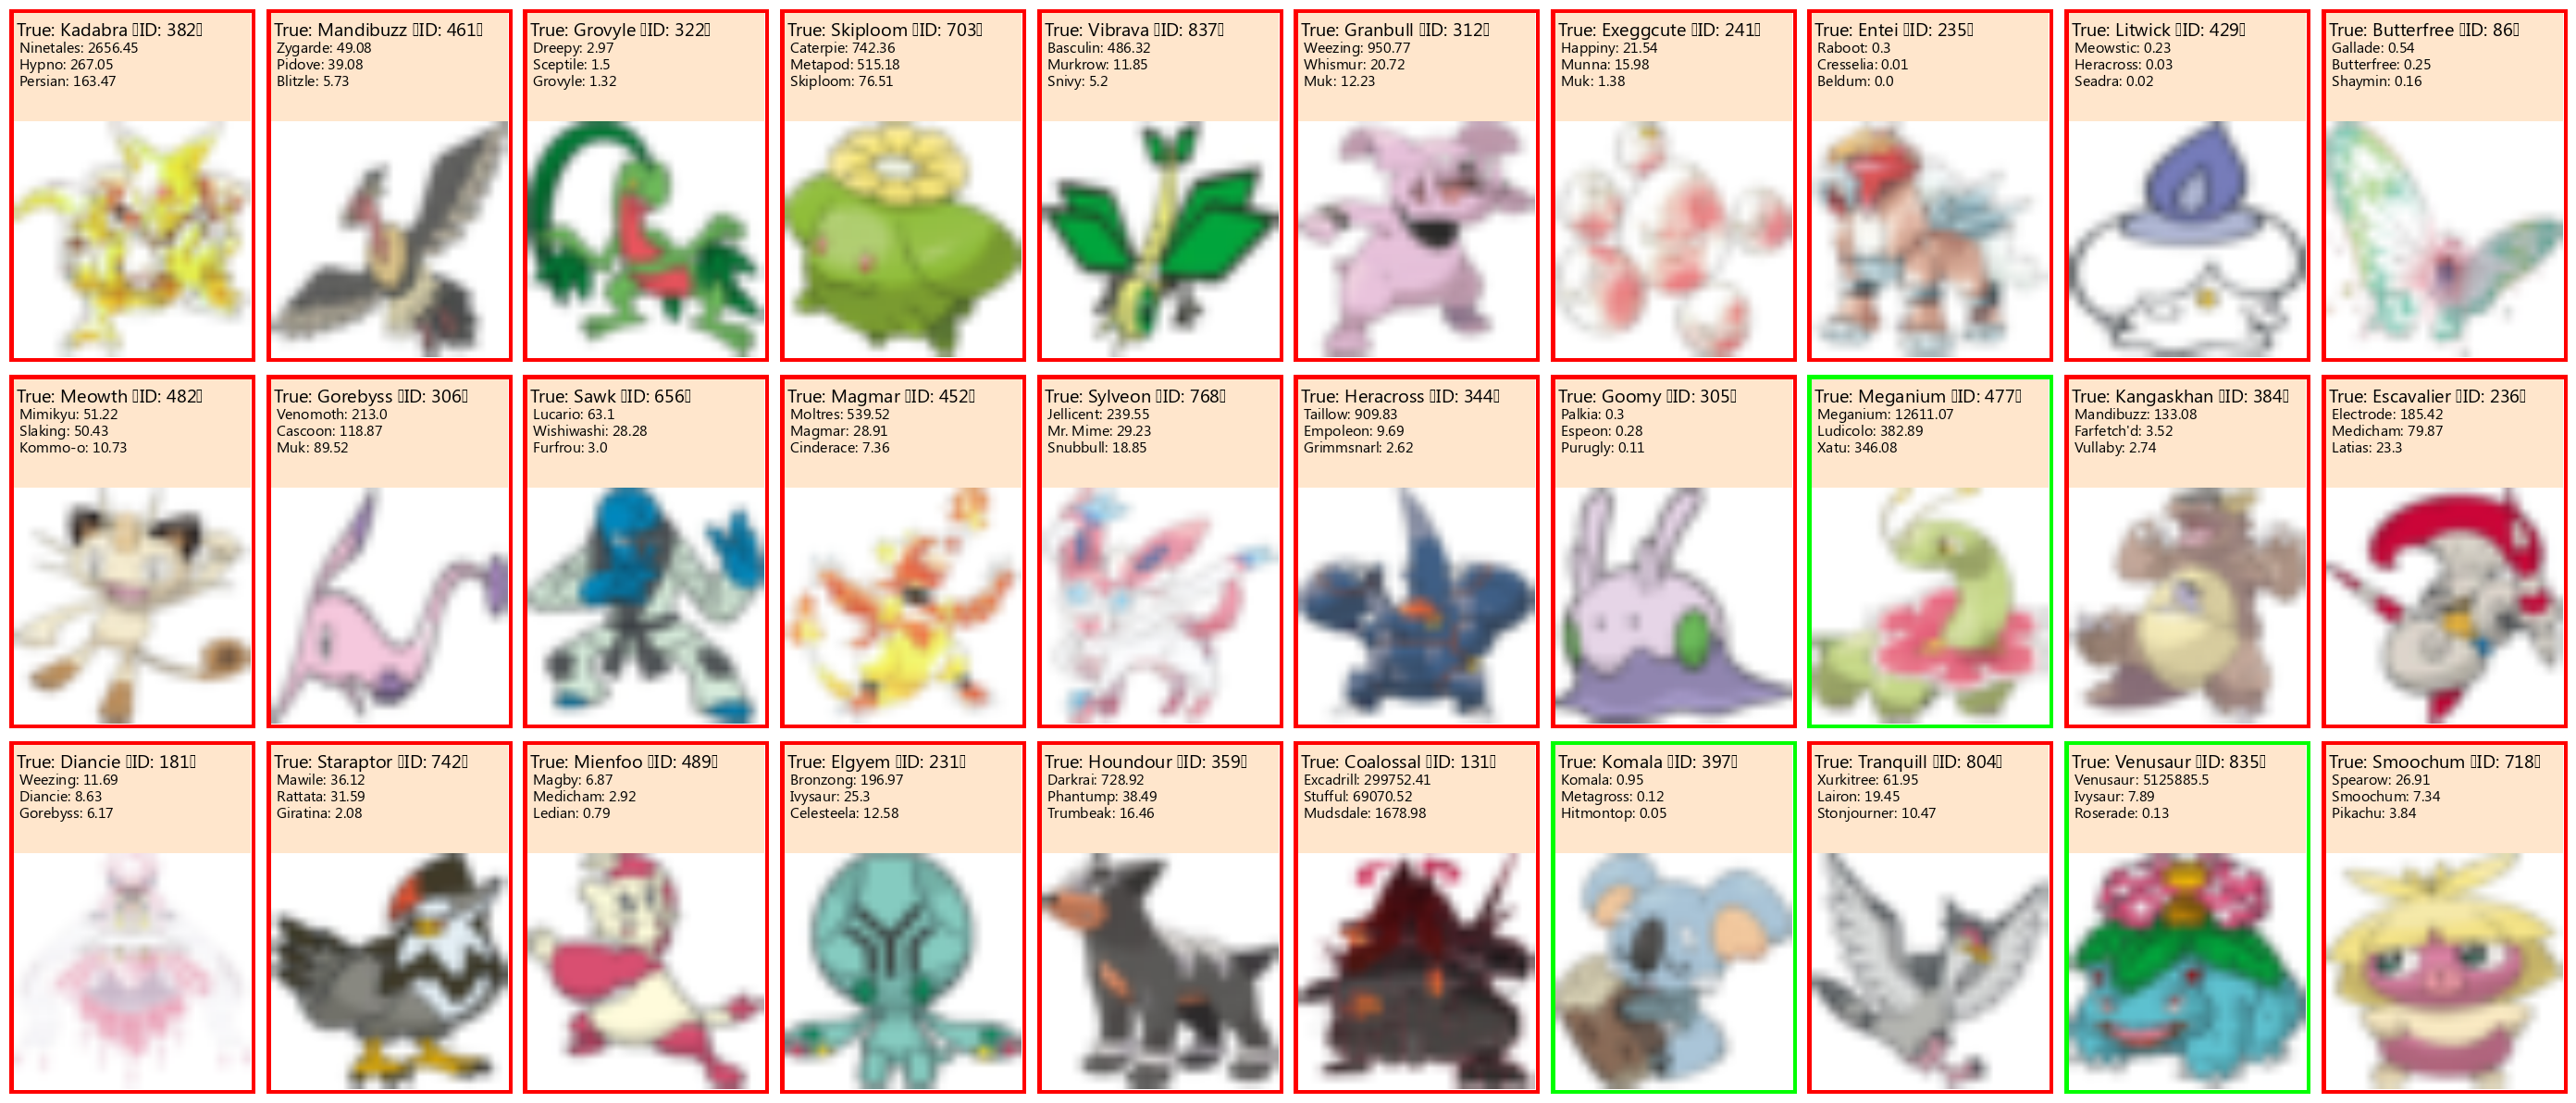

In [20]:
# Создание экземпляра модели
model = ResNet18().to(DEVICE)

checkpoint = torch.load(os.path.join(PATH_TO_MODEL, "ResNet_14_22.88_checkpoint.pth"))
model.load_state_dict(checkpoint['model_state_dict'])

# Отображение примеров из тестовой поддвыборки
ModelTrainer.visualize_samples_with_predictions(
    model = model,
    device = DEVICE,
    cid = dataset_test,
    sample_name = "тестовой",
    path_to_font = PATH_TO_FONT,
    cols = 10,
    rows = 3,
    fz = 20,
    pad = 3,
    outline_width = 0,
    border_thickness = 5,
    line_spacing = 1,
    seed = SEED
)

### Выводы

#### Какие процессы не работают?
Попробовав простые архитектуры нейросетей (`MiniVGGNet`) у меня не удалось достичь практически никакого результата (точность была около 1% на тесте), также изначально я использовал датасет, в котором добавлял только 3 аугменторваные картинки. Этого оказалось недостаточно.

#### Какие проблемы были решены?
Взяв новую модель (`ResNet18`) и увеличив количество аугментированых картинок до 10, удалось значительно поднять качество предсказаний (точность стала больше 20% на тесте).

#### Какие метрики достигнуты?
`accuracy = 22.8%`

#### Какие улучшения могли бы быть добавлены?
Улучшить предсказания можно с помощью улучшения датасета (мы видми, что существуют классы только с 1й картинкой), с помощью большего числа аугментрованых картинок, с помощью более сложной архитектуры нейросети.